# Table of contents
1. [Moving average agent](#1-bullet)
2. [Signal rolling agent](#2-bullet)


## 1. [Moving average agent](#1-bullet)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [16]:

df = pd.read_csv('E:\C\ICT\Machine Learning and Data Mining\ML-DM-Stock-Price-Prediction\Dataset\VCB.csv')
df.head()

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,1,1/4/2016,19720,19900,19260,19530,761750,VCB
1,2,1/5/2016,19400,19620,19170,19220,1133260,VCB
2,3,1/6/2016,19220,19530,19220,19440,699490,VCB
3,4,1/7/2016,19350,19400,18990,19220,935460,VCB
4,5,1/8/2016,19130,19260,18860,19080,676340,VCB


In [17]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2076\348041513.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:]


,signal,short_ma,long_ma,positions
0,0.0,19530.000000,19530.000000,NaN
1,0.0,19375.000000,19375.000000,0.0
2,0.0,19396.666667,19396.666667,0.0
3,0.0,19352.500000,19352.500000,0.0
4,0.0,19298.000000,19298.000000,0.0
...,...,...,...,...
2082,1.0,93651.923077,90315.384615,0.0
2083,1.0,93676.923077,90387.500000,0.0
2084,1.0,93725.000000,90445.192308,0.0
2085,1.0,93765.384615,90499.038462,0.0


In [18]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [19]:
states_buy, states_sell, total_gains, invest = buy_stock(df.close, signals['positions'])

day 66: total balances 10000.000000, not enough money to buy a unit price 19040.000000
day 210: cannot sell anything, inventory 0
day 275: total balances 10000.000000, not enough money to buy a unit price 24210.000000
day 330: cannot sell anything, inventory 0
day 376: total balances 10000.000000, not enough money to buy a unit price 24110.000000
day 432: cannot sell anything, inventory 0
day 441: total balances 10000.000000, not enough money to buy a unit price 25080.000000
day 599: cannot sell anything, inventory 0
day 668: total balances 10000.000000, not enough money to buy a unit price 39470.000000
day 723: cannot sell anything, inventory 0
day 787: total balances 10000.000000, not enough money to buy a unit price 40490.000000
day 1047: cannot sell anything, inventory 0
day 1116: total balances 10000.000000, not enough money to buy a unit price 54450.000000
day 1184: cannot sell anything, inventory 0
day 1194: total balances 10000.000000, not enough money to buy a unit price 57380

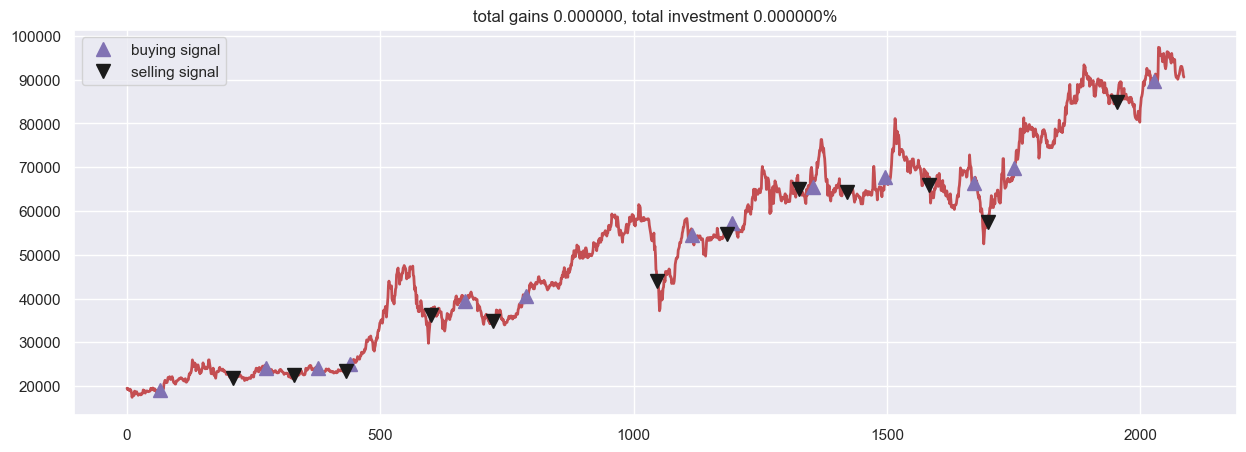

In [20]:
close = df['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

## 2. [Signal rolling agent](#2-bullet)

In [21]:
def buy_stock(
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    for i in range(1, real_movement.shape[0], 1):
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [22]:
states_buy, states_sell, total_gains, invest = buy_stock(df.close, initial_state = 1, 
                                                            delay = 4, initial_money = 10000)

day 0: total balances 10000.000000, not enough money to buy a unit price 19530.000000
day 15: cannot sell anything, inventory 0
day 22: total balances 10000.000000, not enough money to buy a unit price 17910.000000
day 30: cannot sell anything, inventory 0
day 41: total balances 10000.000000, not enough money to buy a unit price 18810.000000
day 50: cannot sell anything, inventory 0
day 59: total balances 10000.000000, not enough money to buy a unit price 18490.000000
day 68: cannot sell anything, inventory 0
day 85: total balances 10000.000000, not enough money to buy a unit price 21700.000000
day 99: cannot sell anything, inventory 0
day 110: total balances 10000.000000, not enough money to buy a unit price 21570.000000
day 121: cannot sell anything, inventory 0
day 136: total balances 10000.000000, not enough money to buy a unit price 23510.000000
day 147: cannot sell anything, inventory 0
day 163: total balances 10000.000000, not enough money to buy a unit price 25100.000000
day 17

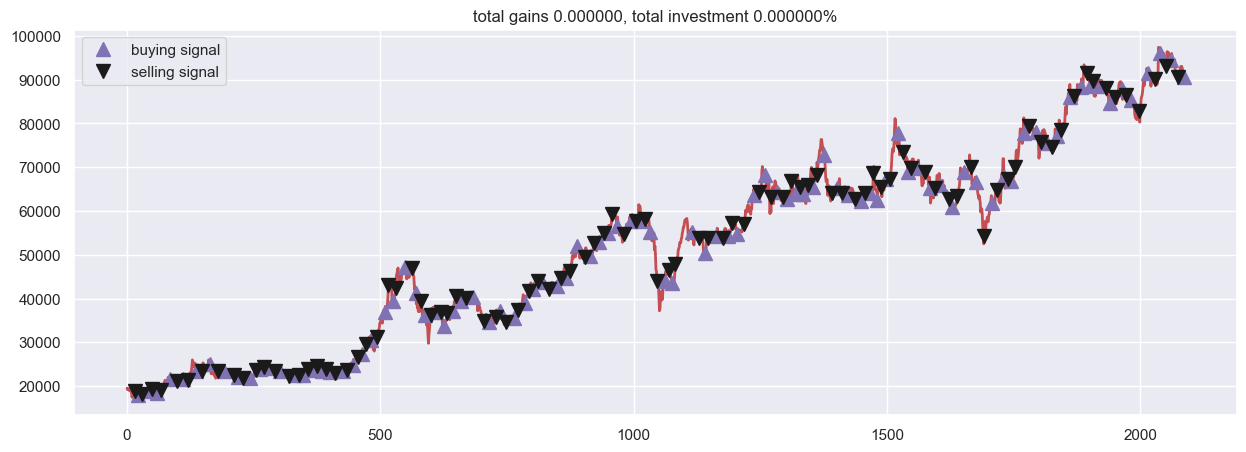

In [23]:
close = df['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()